In [1]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5
import os
# os.environ["OMP_NUM_THREADS"] = "48"

In [2]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
gbls_inputs.filename = "tlc"+str(tic)+"_5.dn.dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [3]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]

# # Detrender
# tpy5.run_polyfilter(phot, tpy5_inputs) -- will add flux_f to phot class

# # Outlier rejection
# tpy5.run_cutoutliers(phot, tpy5_inputs)

freqs:  0.005603552331655075 2.0
nstep:  129976


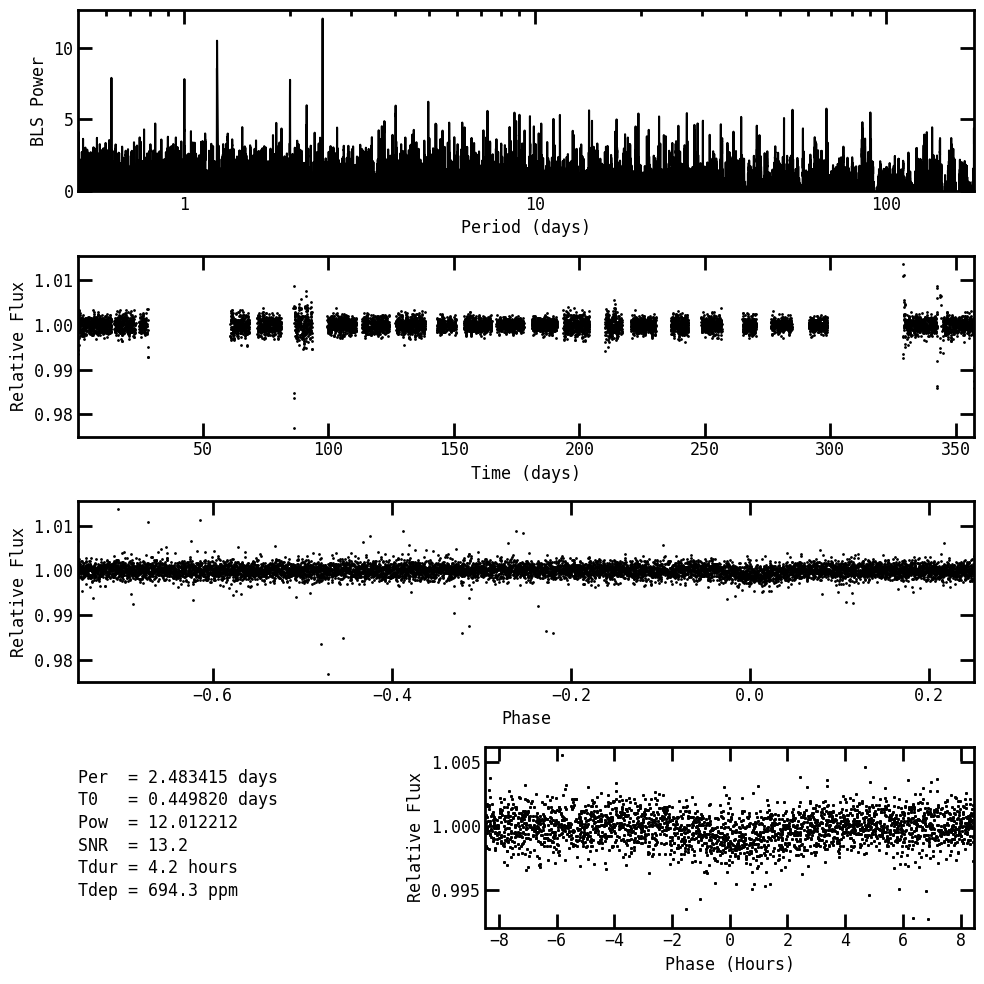

In [3]:
# If you used data processing, use phot.flux_f
# importlib.reload(gbls)
gbls_ans = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

## Transit Modelling Section 

Note: in the utils folder run the following

`f2py -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  
  
`f2py -c fittransitmodel3.pyf precision.f90 fittermod.f90 fittransitmodel3.f90 getrhosig.f minpack.f transitmodel.f occultquad.f keplerian.f mandelagol.f ttcor.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  

and then copy (or move) the created `.so` files to the main code folder.

In [24]:
import transitfit5 as tf5 # will only load if the .so files are present (tfit5 and fittransitmodel.so
import utils_python.transitmodel as transitm
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp
import matplotlib.pyplot as plt
import importlib
import time

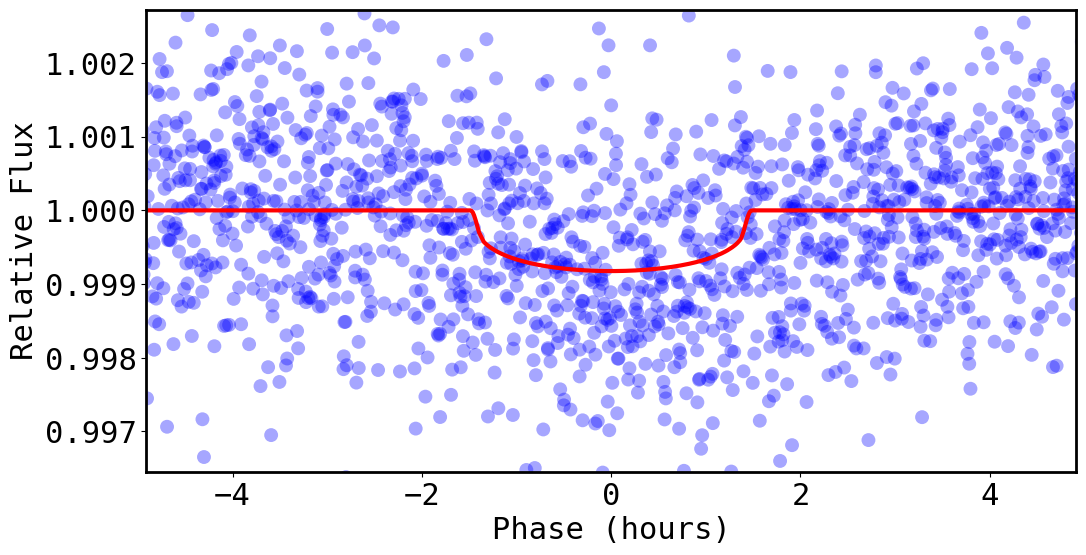

In [12]:
# A basic transit model

bper = 2.483415
epo = 0.44982
rp_rs = 0.0263

sol = np.zeros(18) # single planet model has up-to 18-model parameters

sol[0]  = 0.6  # Mean stellar density (g/cm^3)
sol[1]  = 0.0  # Only used for non-linear limb-darkening
sol[2]  = 0.0  # Only used for non-linear limb-darkening
sol[3]  = 0.6  # q1 (limb-darkening)
sol[4]  = 0.4  # q2 (limb-darkening)
sol[5]  = 0.0  # dilution
sol[6]  = 0.0  # Velocity offset
sol[7]  = 0.0  # photometric zero point
sol[8]  = epo            # Center of transit time (days)
sol[9]  = bper           # Orbital Period (days)
sol[10] = 0.5                    # Impact parameter
sol[11] = rp_rs # Rp/R*
sol[12] = 0.0  # sqrt(e)cos(w)
sol[13] = 0.0  # sqrt(e)sin(w)
sol[14] = 0.0  # RV amplitude (m/s)
sol[15] = 0.0  # thermal eclipse depth (ppm)
sol[16] = 0.0  # Ellipsodial variations (ppm)
sol[17] = 0.0  # Albedo amplitude (ppm)
tf5.transitplot(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol, itime = phot.itime)

ρ (g/cm³):                      0.5144039
c1:                                   0.0
c2:                                   0.0
q1:                                   0.6
q2:                                   0.4
Dilution:                             0.0
Velocity Offset:                      0.0
Photometric zero point:         2.422e-05
t0 (days):                      0.4446551
Period (days):                  2.4835763
Impact parameter:               0.5477459
Rp/R*:                          0.0286011
sqrt(e)cos(w):                        0.0
sqrt(e)sin(w):                        0.0
RV Amplitude (m/s):                   0.0
Thermal eclipse depth (ppm):          0.0
Ellipsoidal variations (ppm):         0.0
Albedo amplitude (ppm):               0.0


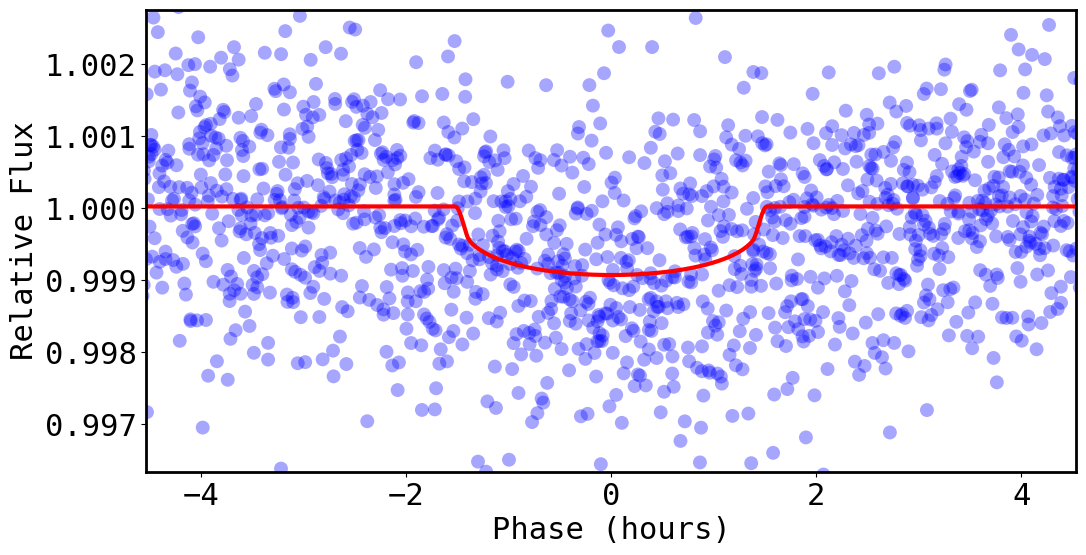

In [89]:
importlib.reload(transitf)
importlib.reload(transitp)

time_a = phot.time - gbls_inputs.zerotime
# transitp.plotTransit(time_a, phot.flux+1, sol, phot.itime)

sol_fit = transitf.fitFromBLS(gbls_ans, time_a, phot.flux + 1, 1, phot.itime)
transitp.printParams(sol_fit)
transitp.plotTransit(time_a, phot.flux + 1, sol_fit, phot.itime)

In [18]:
# Python vs fortran
importlib.reload(transitm)

# import numba
# numba.set_num_threads(48)

transitm.transitModel(sol, phot.time, phot.itime)

print("Python time:")
%timeit transitm.transitModel(sol, phot.time, phot.itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, phot.time, itime = phot.itime)

Python time:
106 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fortran time:
59.5 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# Python vs fortran. More points
importlib.reload(transitm)

n = int(1e6)

t_min = min(phot.time)
t_max = max(phot.time)
time_a = np.linspace(t_min, t_max, n)
itime = np.full(n, phot.itime[0])

transitm.transitModel(sol, time_a, itime)

print("Python time:")
%timeit transitm.transitModel(sol, time_a, itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, time_a, itime = itime)

Python time:
1.28 s ± 57.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fortran time:
1.49 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
